# Example 2 - Pine Island Glacier

This notebook provides an example of a typical ISSM workflow to complete the following:

1. Build and parameterise an ISSM model
2. Conduct a basal friction inversion
3. Run a Higher-Order (HO) Stress balance simulation

We use the Pine Island Glacier (PIG) as our model domain and use a combination of observational and model output data sets to parameterise the model.

In [1]:
import os
import pyissm
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

---
## Setup your modelling environment

This notebook is designed to be executed on the [NCI _Gadi_ supercomputer](https://opus.nci.org.au/spaces/Help/pages/90308778/0.+Welcome+to+Gadi#id-0.WelcometoGadi-Overview), or locally on your personal machine. The notebook assumes the location of additional required assests and model execution directories that may be affected by read/write permissions on NCI *Gadi*, as well as the installation location of pyISSM. Below, we provide information on necessary filesystem requirements to execute this notebook.

### NCI Gadi Supercomputer

By default, we assume that users have installed pyISSM (and therefore, this notebook) in their home directory: `/home/<group>/<user>/pyISSM/`. We refer to this path as `pyissm_home`.

### Local machine

By default, we assume that users have installed pyISSM (and therefore, this notebook) in their home directory: `~/pyISSM/`. We refer to this path as `pyissm_home`

### Required paths

To ensure successful execution of this notebook, users must ensure the following paths are defined correctly in the below cell:

- `tutorial_dir = <PATH_TO_NOTEBOOK>` where this notebook is located. By default, this is assumed to be `pyissm_home/tutorials`
- `tutorial_asset_dir = <PATH_TO_ASSETS>` where all tutorials assets are located. By default, this is assumed to be `pyissm_home/tutorials/assets`
- `execution_dir = <PATH_TO_DIRECTORY>` where model files will be saved. You must have `rwx` permissions for this directory. By default, this is assumed to be `pyissm_home/tutorials/models`

**NOTE: `execution_dir` must be different from the current working directory of your Python kernel.**



In [2]:
## Set required paths
tutorial_dir = str(Path.home() / 'pyISSM' / 'tutorials')
asset_dir = tutorial_dir + '/assets'
execution_dir = tutorial_dir + '/models'

# Check that execution directory exists. If not, create it
if not os.path.isdir(execution_dir):
    os.mkdir(execution_dir)

# Print the paths for visibility
print(f"The following `tutorial_dir` is set: {tutorial_dir}")
print(f"The following `asset_dir` is set: {asset_dir}")
print(f"The following `execution_dir` is set: {execution_dir}")

The following `tutorial_dir` is set: /home/565/lb9857/pyISSM/tutorials
The following `asset_dir` is set: /home/565/lb9857/pyISSM/tutorials/assets
The following `execution_dir` is set: /home/565/lb9857/pyISSM/tutorials/models


---
## Input datasets

This notebook requires various datasets be available for model parameterisation. By default, we make use of the [ACCESS Community Cryosphere Datapool (CCD)](https://github.com/ACCESS-NRI/access-cryosphere-data-pool), available on NCI *Gadi*. However, if the CCD is not available (or not configured for local use) on your local machine, required datasets can be loaded using `xarray`. If you are not working on NCI *Gadi* (or have not configured the CCD for local use), please update the local paths to required datasets in the below cell.

**NOTE: This step is also required in the `assets_dir/pig_param.py` parameter file.**


In [3]:
try:
    ## BY DEFAULT: Load data using the CCD
    import datapool as dp
    print(f"All required datasets will be loaded from the ACCESS Community Cryosphere Datapool on {pyissm.tools.config.get_hostname()}.")

    # Initialise catalog
    catalog = dp.catalog.DataCatalog()

    # Load MEaSUREs velocity v2 dataset
    velocity = catalog.load_dataset('measures_insar_based_antarctica_ice_velocity_map', version = 'v2')

    # Load MEaSUREs BedMachine v3 dataset
    bm = catalog.load_dataset('measures_bedmachine_antarctica')
except:
    ## WORKING LOCALLY: Load data directly using xarray
    print(f"The ACCESS Community Cryosphere Datapool is not accessible on {pyissm.tools.config.get_hostname()}. Please update the paths to the required input datasets below.")
    import xarray as xr

    ## To load datasets locally using xarray, please update the following paths
    velocity = xr.open_dataset("<PATH_TO_MEASURES_V2_ICE_VELOCITY_DATASET>")
    bm = xr.open_dataset("<PATH_TO_MEASURES_BEDMACHINCE_V3_DATASET>")

All required datasets will be loaded from the ACCESS Community Cryosphere Datapool on gadi-cpu-bdw-0001.gadi.nci.org.au.


---
## 1. Model mesh

In this example, we first generate a uniform mesh with a resolution of 10 km. We then refine this mesh based on the observed velocity field using anisotropic mesh refinement. At each step, we plot the mesh and velocity field.

In [4]:
# Define initial mesh parameters
hinit = 10000

# Generate initial uniform mesh
md = pyissm.model.mesh.bamg(pyissm.model.Model(),
                            domain = asset_dir + '/Exp/PIG_DomainOutline.exp',
                            hmax = hinit)

Text(0.5, 1.0, 'Initial uniform model mesh')

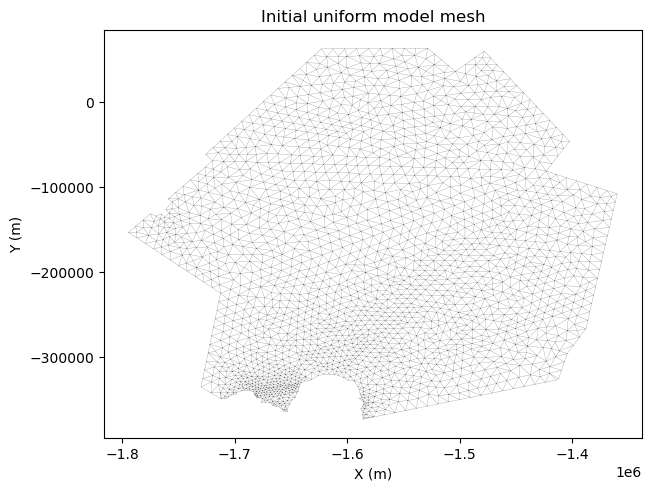

In [5]:
# Visualise initial uniform mesh
fig, ax = pyissm.plot.plot_mesh2d(md)
ax.set_title('Initial uniform model mesh')

Here, we interpolate the velocity data onto the model mesh using the default "bilinear" interpolation technique. We use the `fill_nan` option to automatically fill remaining NaN values using nearest-neighbour (default) interpolation to ensure a complete velocity field. We then plot the observed velocity field on the model mesh, passing some optional arguments to tailor the appearance of the plot.

In [6]:
# Assign velocity to model
vx_mesh = pyissm.data.interp.xr_to_mesh(velocity, 'VX', md.mesh.x, md.mesh.y, fill_nan = True)
vy_mesh = pyissm.data.interp.xr_to_mesh(velocity, 'VY', md.mesh.x, md.mesh.y, fill_nan = True)
vel_mesh = np.sqrt(vx_mesh**2 + vy_mesh**2)

Text(0.5, 1.0, 'Observed velocity')

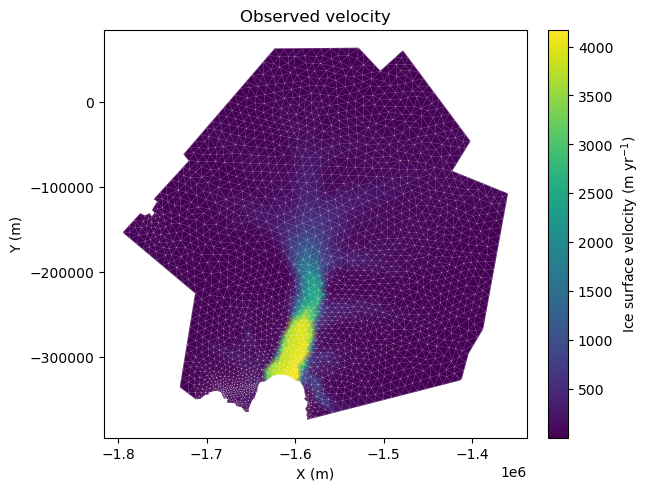

In [7]:
# Visualise velocity
fig, ax = pyissm.plot.plot_model_field(md,
                                       vel_mesh,
                                       show_mesh = True,
                                       mesh_kwargs = {'color': 'white'},
                                       show_cbar = True,
                                       cbar_kwargs = {'label': 'Ice surface velocity (m yr$^{-1}$)'})
ax.set_title('Observed velocity')

Next, we refine the model mesh based on the observed velocity field. We define a maximum (`hmax`) and minmum (`hmin`) vertex length, as well as gradation and err value for the refinement. Adjusting these parameters influences the degree of mesh refinement. We then visualise the refined mesh.

In [8]:
# Define mesh refinement parameters
hmax = 40000
hmin = 5000
gradation = 1.7
err = 8

# Adapt the mesh based on the velocity
md = pyissm.model.mesh.bamg(md,
                            hmax = hmax,
                            hmin = hmin,
                            gradation = gradation,
                            field = vel_mesh,
                            err = err)

Text(0.5, 1.0, 'Refined model mesh')

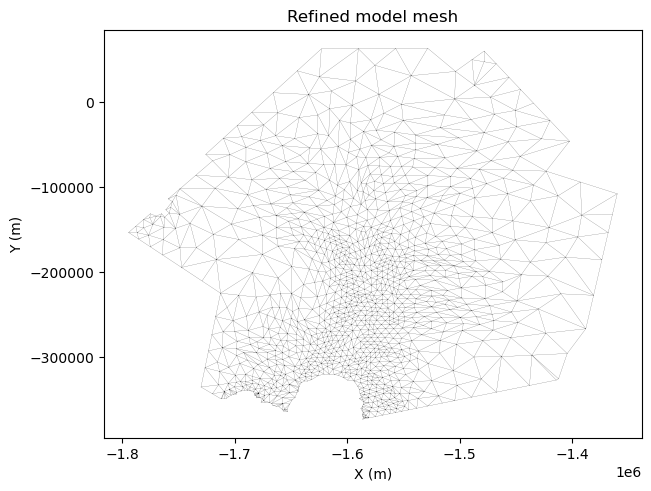

In [9]:
# Visualise refined mesh
fig, ax = pyissm.plot.plot_mesh2d(md)
ax.set_title('Refined model mesh')

Finally, we save the model mesh for use in subsequent steps. By default, this is saved alongside this notebook in the `tutorial_dir`.

In [10]:
# Save the model
pyissm.model.io.save_model(md, tutorial_dir + '/ex2_PIG_mesh.nc')

---
## 2. Model Mask

Next, we define regions of ice/no-ice and grounded/floating ice. To do this, we use the  `mask` variable from BedMachine v3 (`bm` variable loaded at the beginning of this notebook). We first load the model from the precedeing step, then interpolate the mask onto the model mesh, and finally designate ice/no-ice and grounded/floating ice based on the mask values. We visualise the fields after each step.

In [11]:
# Load the model
md = pyissm.model.io.load_model(tutorial_dir + '/ex2_PIG_mesh.nc')

When interpolating the `mask` variable, we use the nearest-neighbour interpolation (`interpolation_type = 'nearest') to preserve the unique binary values of the mask. We then visualise the native mask on the model mesh.

In [12]:
# Interpolate mask to model mesh
## NOTE: Use interpolation_type = 'nearest' to retain unique values for mask
mask = pyissm.data.interp.xr_to_mesh(bm, 'mask', md.mesh.x, md.mesh.y, interpolation_type = 'nearest')

Text(0.5, 1.0, 'Native BedMachine v3 mask')

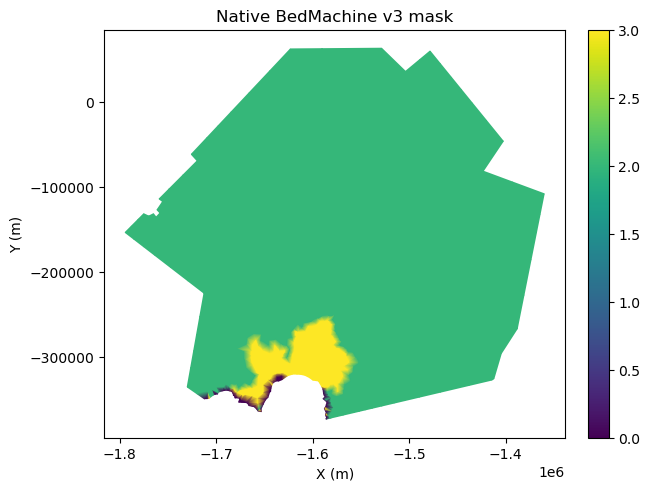

In [13]:
# Visuaise the mask
fig, ax = pyissm.plot.plot_model_field(md, mask, show_cbar = True)
ax.set_title('Native BedMachine v3 mask')

The `md.mask.ice_levelset` and `md.mask.ocean_levelset` fields interact to define where there is grounded ice, floating ice, ice-free regions, and open ocean within the model domain, as follows:

- `ice_levelset` < 0: Ice present
- `ice_levelset` = 0: Ice-front position
- `ice_levelset` > 0: No ice present
- `ocean_levelset` <0: Ocean present
- `ocean_levelset` = 0: Coastline / grounding line
- `ocean_levelset` > 0: No ocean present

Next, we discretise the `mask` variable as required and visualise both the `md.mask.ocean_levelset`, `md.mask.ice_levelset` fields, as well as their interaction to define grounding ice and floating ice within the model domain. We visualise the results and save the model for future use.

In [14]:
# Create empty levelset variables
ice_levelset = np.full(md.mesh.numberofvertices, np.nan)
ocean_levelset = np.full(md.mesh.numberofvertices, np.nan)

# Define ice / no-ice areas
ice_levelset[mask > 0] = -1
ice_levelset[np.isnan(ice_levelset)] = 1

# Define ocean / no-ocean areas
ocean_levelset[mask == 2] = 1
ocean_levelset[mask == 3] = -1
ocean_levelset[mask == 0] = -1

# Assign to model
md.mask.ice_levelset = ice_levelset
md.mask.ocean_levelset = ocean_levelset

Text(0.5, 1.0, 'Floating ice elements')

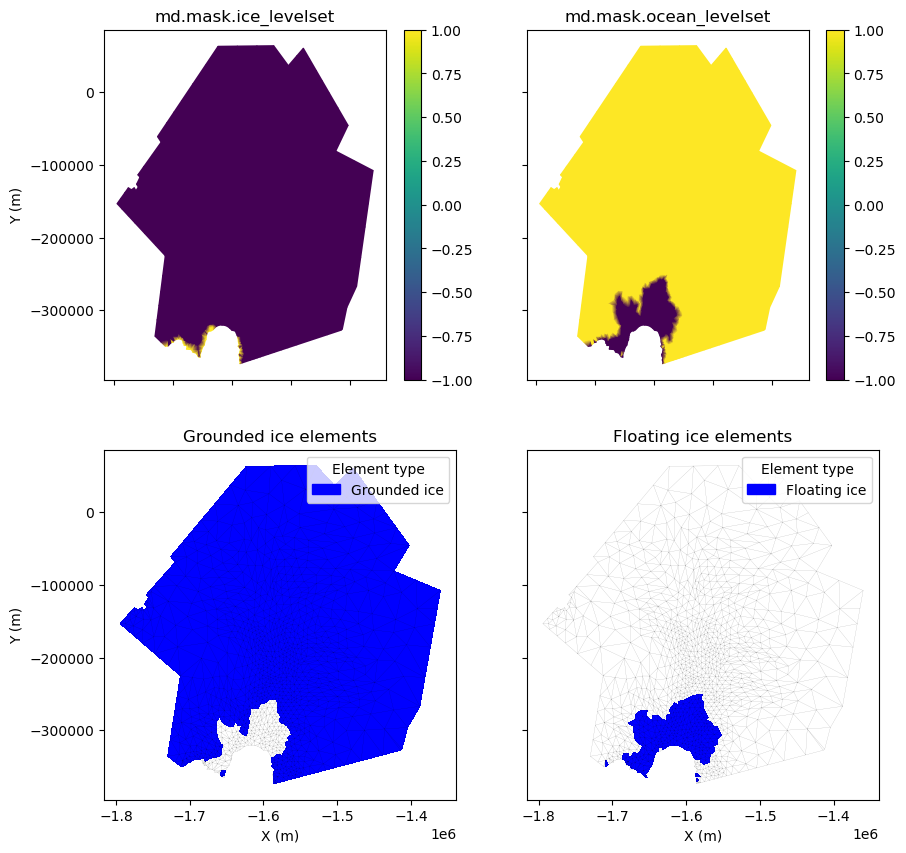

In [15]:
# Visualise elements
## NOTE: pyissm.plot.plot_model_elements() define elements as floating/grounded if ANY node of the element is considered floating/grounded. Therefore, this includes "partially floating/grounded" elements.
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (10, 10), sharex = True, sharey = True)
ax1 = pyissm.plot.plot_model_field(md, md.mask.ice_levelset, ax = ax1, show_cbar = True, xlabel = '')
ax2 = pyissm.plot.plot_model_field(md, md.mask.ocean_levelset, ax = ax2, show_cbar = True, ylabel = '', xlabel = '')
ax3 = pyissm.plot.plot_model_elements(md, md.mask.ice_levelset, md.mask.ocean_levelset, type = 'grounded_ice_elements', ax = ax3)
ax4 = pyissm.plot.plot_model_elements(md, md.mask.ice_levelset, md.mask.ocean_levelset, type = 'floating_ice_elements', ax = ax4, ylabel = '')

ax1.set_title('md.mask.ice_levelset')
ax2.set_title('md.mask.ocean_levelset')
ax3.set_title('Grounded ice elements')
ax4.set_title('Floating ice elements')

In [16]:
# Save the model
pyissm.model.io.save_model(md, tutorial_dir + '/ex2_PIG_mask.nc')

---
## 3. Parameterize Model

Before we can execute a model, we must "parameterise" the model to define necessary components. This includes specifying model components such as ice geometry, initial conditions, friction representation, etc. Here, we utilise the `pyissm.model.paramparameterize()` function that allows use to keep the bulk of the parameterization code separate from this execution script.

**NOTE: If you are not using the ACCESS CCD to load your datsets, you'll need to update the dataset paths at the top of the `assets_dir/Param/pig_param.py` file before proceeding.**

Here, we load the model from the preceding step, run the parameteriZation file, define the Shelgy-Stream Approximation (SSA) flow approximation across the whole domain, and plot some of the parameterized fields before saving the model again.

In [17]:
# Load the model
md = pyissm.model.io.load_model(tutorial_dir + '/ex2_PIG_mask.nc')

In [18]:
# Parameterize the model
md = pyissm.model.param.parameterize(md, asset_dir + '/Param/pig_param.py')

All required datasets will be loaded from the ACCESS Community Cryosphere Datapool on gadi-cpu-bdw-0001.gadi.nci.org.au.
 -- LOADING DATASETS -- 


/scratch/tm70/lb9857/access-cryosphere-data-pool/src/datapool/loaders.py:530: UserWarning: WARNING: Timesteps vary between various variables/files. All data files are loaded using
xr.open_mfdataset() and the timestamps are merged. As a result, all-NaN arrays are introduced
for timesteps where a given variable does not have data. Users should use caution when considering
time-varying analysis and might consider 'trimming' data to isolate all non-NaN arrays for a given variable.
  warnings.warn("WARNING: Timesteps vary between various variables/files. All data files are loaded using\n"


 -- ASSIGNING GEOMETRY -- 
 -- ASSIGNING INITIALIZATION FIELDS -- 
ll_to_xy: using south polar stereographic (Std Lat: 71S, Meridian: 0E)
 -- ASSIGNING FORCINGS -- 
ll_to_xy: using south polar stereographic (Std Lat: 71S, Meridian: 0E)
 -- SETTING BOUNDARY CONDITIONS -- 


/home/565/lb9857/gitRepos/pyISSM/src/pyissm/model/bc.py:95: UserWarning: pyissm.model.bc._set_sb_dirichlet_bc: Using observed velocities for vx and vy stressbalance model boundary conditions. vz boundary conditions are set to 0.
  warnings.warn('pyissm.model.bc._set_sb_dirichlet_bc: Using observed velocities for vx and vy stressbalance model boundary conditions. vz boundary conditions are set to 0.')
/home/565/lb9857/gitRepos/pyISSM/src/pyissm/model/classes/basalforcings.py:116: UserWarning: pyissm.model.classes.basalforcings.default: no groundedice_melting_rate specified -- values set as 0
  warnings.warn('pyissm.model.classes.basalforcings.default: no groundedice_melting_rate specified -- values set as 0')
/home/565/lb9857/gitRepos/pyISSM/src/pyissm/model/classes/basalforcings.py:120: UserWarning: pyissm.model.classes.basalforcings.default: no floatingice_melting_rate specified -- values set as 0
  warnings.warn('pyissm.model.classes.basalforcings.default: no floatingice_melting_rate

In [19]:
# Set flow equation (SSA)
md = pyissm.model.param.set_flow_equation(md, SSA = 'all')

Text(0.5, 1.0, 'md.smb.mass_balance')

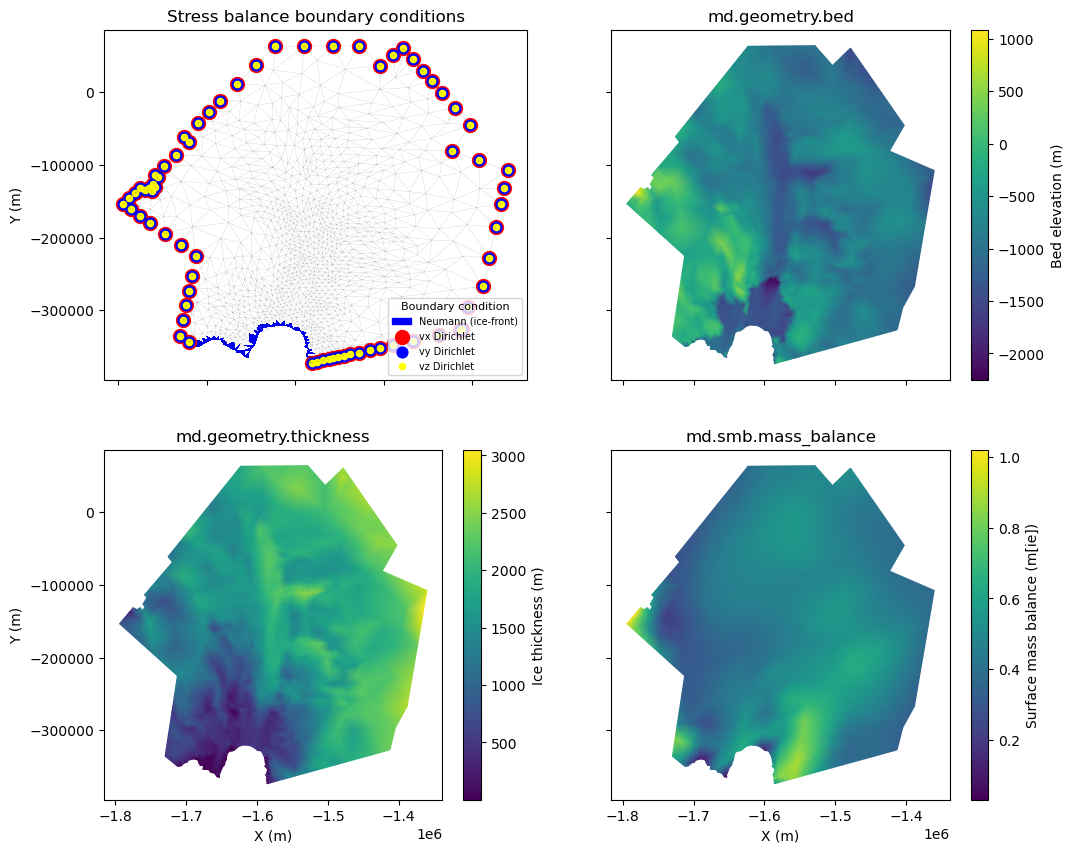

In [20]:
# Visualise various parameterized fields
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (12, 10), sharex = True, sharey = True)
ax1 = pyissm.plot.plot_model_bc(md, ax = ax1, xlabel = '', legend_kwargs = {'fontsize': 7, 'title_fontsize': 8, 'loc': 'lower right'})
ax2 = pyissm.plot.plot_model_field(md, md.geometry.bed, ax = ax2, show_cbar = True, xlabel='', ylabel = '', cbar_kwargs = {'label': 'Bed elevation (m)'})
ax3 = pyissm.plot.plot_model_field(md, md.geometry.thickness, ax = ax3, show_cbar = True, cbar_kwargs = {'label': 'Ice thickness (m)'})
ax4 = pyissm.plot.plot_model_field(md, md.smb.mass_balance, ax = ax4, show_cbar = True, ylabel='', cbar_kwargs = {'label': 'Surface mass balance (m[ie])'})

ax1.set_title('Stress balance boundary conditions')
ax2.set_title('md.geometry.bed')
ax3.set_title('md.geometry.thickness')
ax4.set_title('md.smb.mass_balance')

In [21]:
# Save the model
pyissm.model.io.save_model(md, tutorial_dir + '/ex2_PIG_param.nc')

## 4. Perform friction inversion

To infer the basal friction below the ice sheet, we can use inverse techniques. Here, we perform a basal friction inversion to infer the basal friction coefficient based on the default Budd friction law. All parameters that control the inversion are in `md.inversion`. Here, we define a minimum and maximum coefficient value of 1 and 200, respectively. We include 3 cost functions in the inversion, namely: `SurfaceAbsVelMisfit` (101), `SurfaceLogVelMisfit` (103), and `DragCoefficientAbsGradient` (501). We run the inversion for a maximum of 20 steps, with up to 40 iterations per step.


In [22]:
# Load model
md = pyissm.model.io.load_model(tutorial_dir + '/ex2_PIG_param.nc')

In [23]:
# Define inversion parameters
md.inversion.iscontrol = 1
# md.inversion.maxsteps = 20
# md.inversion.maxiter = 40
# md.inversion.dxmin = 0.1
# md.inversion.gttol = 1.0e-4

md.inversion.cost_functions = [101, 103, 501]
md.inversion.cost_functions_coefficients = np.ones((md.mesh.numberofvertices, 3))
md.inversion.cost_functions_coefficients[:,0] = 50
md.inversion.cost_functions_coefficients[:,1] = 1
md.inversion.cost_functions_coefficients[:,2] = 1e-19

md.inversion.control_parameters = ['FrictionCoefficient']
md.inversion.min_parameters = 1 * np.ones(md.mesh.numberofvertices, )
md.inversion.max_parameters = 200 * np.ones(md.mesh.numberofvertices, )

# md.stressbalance.restol = 0.01
# md.stressbalance.reltol = 0.1
# md.stressbalance.abstol = np.nan

md.verbose = md.verbose.deactivate_all()
md.verbose.control = 1

In [24]:
# Solve
md.cluster.np = 2
md.cluster.executionpath = execution_dir

md = pyissm.model.execute.solve(md, 'Stressbalance')

/home/565/lb9857/gitRepos/pyISSM/src/pyissm/model/classes/qmu.py:95: UserWarning: pyissm.model.classes.qmu::qmu not yet implemented. Turning off qmu.
  warnings.warn('pyissm.model.classes.qmu::qmu not yet implemented. Turning off qmu.')


Uploading files to cluster...
Transferring PIG-02-22-2026-14-11-33-1977939.tar.gz to cluster gadi-cpu-bdw-0001.gadi.nci.org.au...
Launching job PIG on cluster gadi-cpu-bdw-0001.gadi.nci.org.au...

Ice-sheet and Sea-level System Model (ISSM) version  4.24
(GitHub: https://issmteam.github.io/ISSM-Documentation/ Documentation: https://github.com/ISSMteam/ISSM/)

call computational core:
   preparing initial solution

       x       |  Cost function f(x)  |  List of contributions
====================== step 1/20 ===============================
 x =         0 | f(x) =     126652.7  |       117147.9      9504.79 4.143434e-16
 x =         1 | f(x) =     18251.12  |       10907.76      7343.36 3.829378e-15
====================== step 2/20 ===============================
 x =         0 | f(x) =     18250.18  |       10906.83     7343.348 3.829378e-15
 x =         1 | f(x) =     4338.843  |       1404.739     2934.104 1.306648e-14
====================== step 3/20 ===============================


Text(0.5, 1.0, 'Velocity misfit (Mod - Obs)')

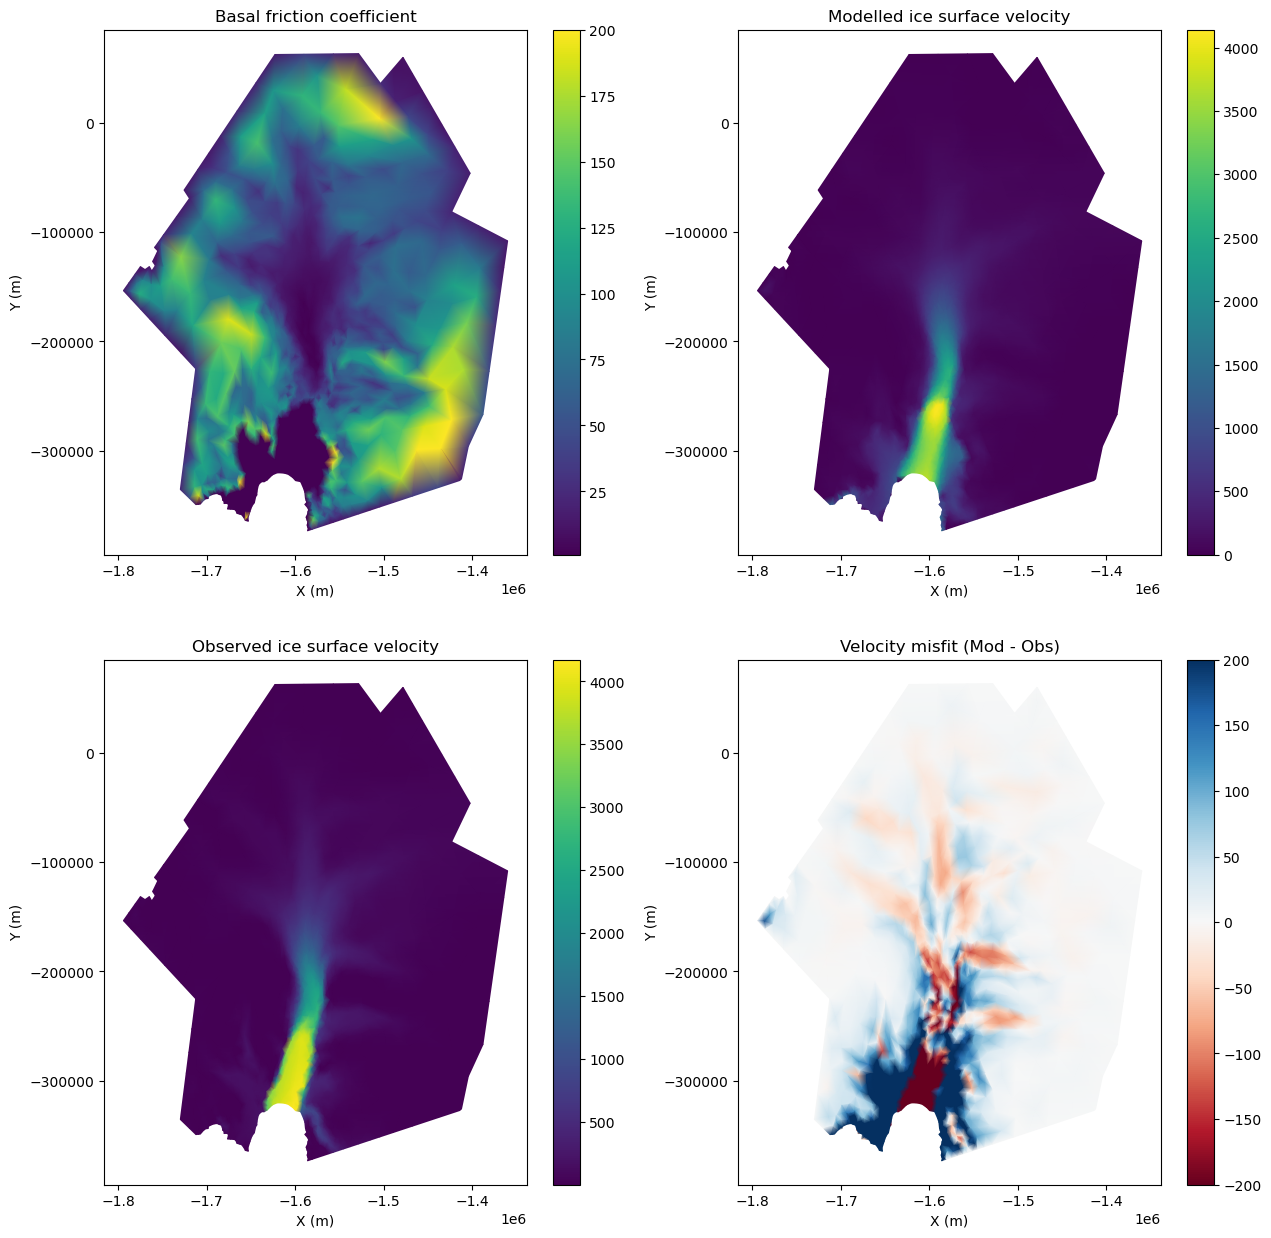

In [25]:
# Visualize the inversion results
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (15, 15))
ax1 = pyissm.plot.plot_model_field(md, md.results.StressbalanceSolution.FrictionCoefficient, show_cbar = True, ax = ax1)
ax2 = pyissm.plot.plot_model_field(md, md.results.StressbalanceSolution.Vel, show_cbar = True, ax = ax2)
ax3 = pyissm.plot.plot_model_field(md, md.inversion.vel_obs, show_cbar = True, ax = ax3)
ax4 = pyissm.plot.plot_model_field(md, md.results.StressbalanceSolution.Vel - md.inversion.vel_obs,
                                   show_cbar = True,
                                   cmap = 'RdBu',
                                   vmin = -200,
                                   vmax = 200,
                                   ax = ax4)

ax1.set_title('Basal friction coefficient')
ax2.set_title('Modelled ice surface velocity')
ax3.set_title('Observed ice surface velocity')
ax4.set_title('Velocity misfit (Mod - Obs)')

In [26]:
## Save the model
pyissm.model.io.save_model(md, tutorial_dir + '/ex2_PIG_control_drag.nc')

## 5. HO Extrusion

Now that we have a SSA model with an appropriate friction approximation, we can extrude the model to a 3D mesh and run a stress balance solution with a Higher-Order (HO) flow approximation. Below, we load the SSA model, disable inversion, extrude the model to give 3 layers, specify the use of the HO flow approximation across the whole domain and execute a stressbalance solution. We then save the model for later visualisation.

**NOTE: We adjust the `solver_residue_threshold` here to ensure successful computation. This is necessary as the friction coefficient is not fully-optimised at this time. This step is not essential for all model setups.**


In [27]:
## Load model
md = pyissm.model.io.load_model(tutorial_dir + '/ex2_PIG_control_drag.nc')

ℹ️ Processing results group: StressbalanceSolution


In [28]:
## Turn off inversion
md.inversion.iscontrol = 0

## Extrude mesh
md = md.extrude(3, 1)

## Change stressbalance approximation
md = pyissm.model.param.set_flow_equation(md, HO = 'all')

## Solve
md.settings.solver_residue_threshold = 0.005
md.verbose.solution = 1
md = pyissm.model.execute.solve(md, 'stressbalance')

Checking model consistency...
Marshalling for PIG.bin


/home/565/lb9857/gitRepos/pyISSM/src/pyissm/model/classes/hydrology.py:1433: UserWarning: pyissm.model.classes.hydrology.shreve.extrude: 3D extrusion not implemented for hydrology.shreve. Returning unchanged (2D) hydrology fields.
  warnings.warn('pyissm.model.classes.hydrology.shreve.extrude: 3D extrusion not implemented for hydrology.shreve. Returning unchanged (2D) hydrology fields.')
/home/565/lb9857/gitRepos/pyISSM/src/pyissm/model/classes/solidearth.py:127: UserWarning: pyissm.model.classes.solidearth.earth.extrude: 3D extrusion not implemented for solidearth.earth. Returning unchanged (2D) solidearth fields.
  warnings.warn('pyissm.model.classes.solidearth.earth.extrude: 3D extrusion not implemented for solidearth.earth. Returning unchanged (2D) solidearth fields.')
/home/565/lb9857/gitRepos/pyISSM/src/pyissm/model/classes/qmu.py:63: UserWarning: pyissm.model.classes.qmu.default.extrude: 3D extrusion not implemented for qmu.default. Returning unchanged (2D) qmu fields.
  warning

Uploading files to cluster...
Transferring PIG-02-22-2026-14-12-25-1977939.tar.gz to cluster gadi-cpu-bdw-0001.gadi.nci.org.au...
Launching job PIG on cluster gadi-cpu-bdw-0001.gadi.nci.org.au...

Ice-sheet and Sea-level System Model (ISSM) version  4.24
(GitHub: https://issmteam.github.io/ISSM-Documentation/ Documentation: https://github.com/ISSMteam/ISSM/)

call computational core:
   computing new velocity
   computing basal mass balance
   computing vertical velocities
write lock file:

   FemModel initialization elapsed time:   0.17533
   Total Core solution elapsed time:       5.16411
   Linear solver elapsed time:             1.37424 (27%)

   Total elapsed time: 0 hrs 0 min 5 sec
Waiting for job to complete...
wait_on_lock not implemented yet
Job completed -- loading results from cluster...
Retrieving results from cluster gadi-cpu-bdw-0001.gadi.nci.org.au...


In [29]:
## Save the model
pyissm.model.io.save_model(md, tutorial_dir + '/ex2_PIG_HO.nc')

## 5.1 Plot velocity differences

Now that we have both an SSA and HO solution, we can compare the resultant modelled velocities. Below, we load the HO and SSA models and plot the modelled velocities. For the HO model, we compare the surface and base velocities.

ℹ️ Processing results group: StressbalanceSolution
ℹ️ Processing results group: StressbalanceSolution


/home/565/lb9857/gitRepos/pyISSM/src/pyissm/model/mesh.py:108: UserWarning: process_mesh: 3D model found. Processing as 2D mesh.
  warnings.warn('process_mesh: 3D model found. Processing as 2D mesh.')
/home/565/lb9857/gitRepos/pyISSM/src/pyissm/model/mesh.py:108: UserWarning: process_mesh: 3D model found. Processing as 2D mesh.
  warnings.warn('process_mesh: 3D model found. Processing as 2D mesh.')
/home/565/lb9857/gitRepos/pyISSM/src/pyissm/model/mesh.py:108: UserWarning: process_mesh: 3D model found. Processing as 2D mesh.
  warnings.warn('process_mesh: 3D model found. Processing as 2D mesh.')


Text(0.5, 1.0, 'HO Surface - Base Velocity')

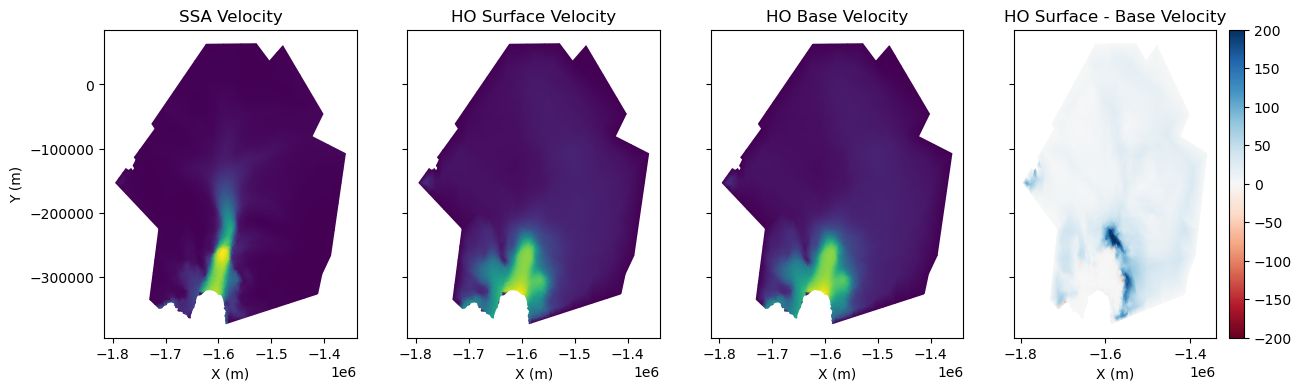

In [30]:
# Load models
md_ho = pyissm.model.io.load_model(tutorial_dir + '/ex2_PIG_HO.nc')
md_ssa = pyissm.model.io.load_model(tutorial_dir + '/ex2_PIG_control_drag.nc')

# Extract relevant velocity fields/layers
ho_surface_vel = md_ho.results.StressbalanceSolution.Vel[md_ho.mesh.vertexonsurface == 1]
ho_base_vel = md_ho.results.StressbalanceSolution.Vel[md_ho.mesh.vertexonbase == 1]
ssa_vel = md_ssa.results.StressbalanceSolution.Vel

# Visualise velocity fields
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (15, 4), sharey = True)
ax1 = pyissm.plot.plot_model_field(md_ssa, ssa_vel, ax = ax1)
ax2 = pyissm.plot.plot_model_field(md_ho, ho_surface_vel, ax = ax2, ylabel = '')
ax3 = pyissm.plot.plot_model_field(md_ho, ho_base_vel, ax = ax3, ylabel = '')
ax4 = pyissm.plot.plot_model_field(md, ho_surface_vel - ho_base_vel, cmap = 'RdBu', show_cbar = True, ax = ax4, vmin = -200, vmax = 200, ylabel = '')

ax1.set_title('SSA Velocity')
ax2.set_title('HO Surface Velocity')
ax3.set_title('HO Base Velocity')
ax4.set_title('HO Surface - Base Velocity')